클래스: ['blocked', 'free']
데이터 수: 60


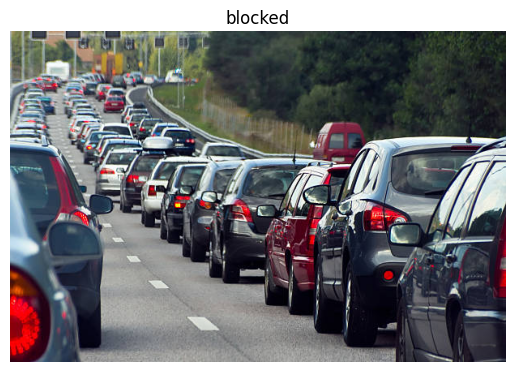

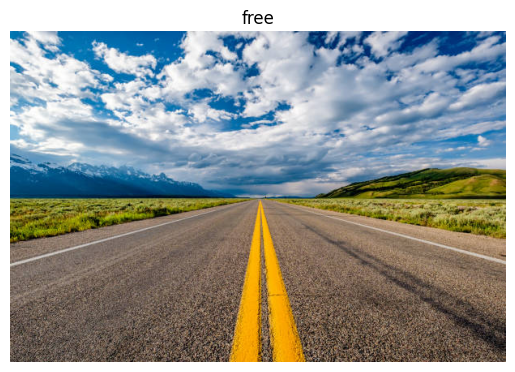

Device: cpu
Epoch 1: Loss=8.37, Accuracy=56.67%
Epoch 2: Loss=5.21, Accuracy=73.33%
Epoch 3: Loss=3.29, Accuracy=80.00%


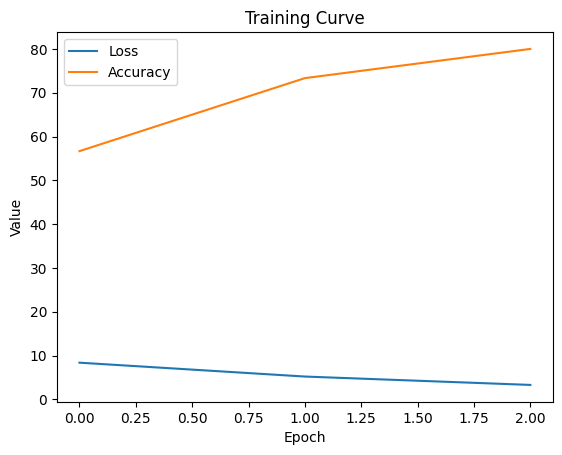

실제 라벨: free | 예측: free


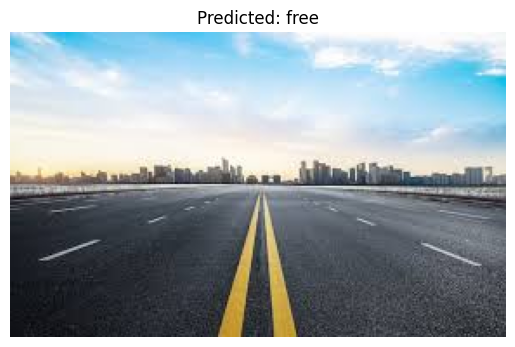

추론 속도: 74.28 FPS


In [3]:
# ============================================
# 0. 라이브러리 임포트
# ============================================
import os, random, time
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# ============================================
# 1. 데이터셋 불러오기
# ============================================
# 데이터 경로 (본인 PC 경로 맞게 수정!)
data_dir = r"C:\Users\ai\Desktop\jetson-nano-project\dataet_classification"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

print("클래스:", dataset.classes)
print("데이터 수:", len(dataset))

# 샘플 이미지 출력
for label in dataset.classes:
    path = os.path.join(dataset.root, label)
    sample = random.choice(os.listdir(path))
    img = Image.open(os.path.join(path, sample)).convert("RGB")
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

# ============================================
# 2. 모델 정의 및 학습
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # free/blocked
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses, accs = [], []

for epoch in range(3):  # 포폴용 3epoch
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    losses.append(running_loss)
    accs.append(acc)
    print(f"Epoch {epoch+1}: Loss={running_loss:.2f}, Accuracy={acc:.2f}%")

# ============================================
# 3. 학습 곡선 시각화
# ============================================
plt.plot(losses, label="Loss")
plt.plot(accs, label="Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curve")
plt.show()

# ============================================
# 4. 추론 테스트
# ============================================
model.eval()
img_path, label = dataset.samples[random.randint(0, len(dataset)-1)]
img = Image.open(img_path).convert("RGB")

input_img = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_img)
    pred = torch.argmax(output, 1).item()

print("실제 라벨:", dataset.classes[label], "| 예측:", dataset.classes[pred])

plt.imshow(img)
plt.title(f"Predicted: {dataset.classes[pred]}")
plt.axis("off")
plt.show()

# ============================================
# 5. FPS 측정 (옵션)
# ============================================
dummy_input = torch.randn(1, 3, 224, 224).to(device)

start = time.time()
for _ in range(100):
    _ = model(dummy_input)
end = time.time()

fps = 100 / (end - start)
print(f"추론 속도: {fps:.2f} FPS")


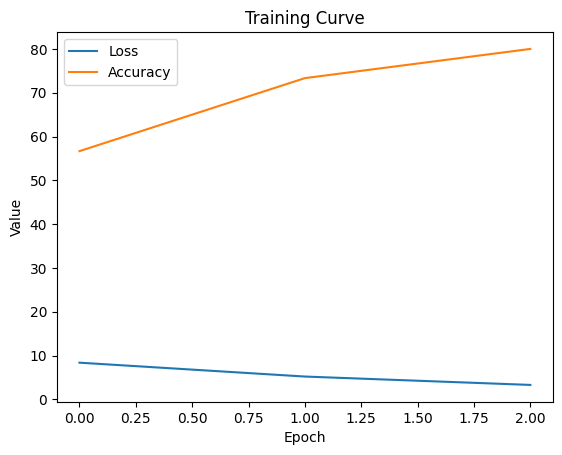

In [4]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Loss")
plt.plot(accs, label="Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curve")
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import csv

# 데이터셋 경로
data_dir = r"C:\Users\ai\Desktop\jetson-nano-project\dataet_classification"

# 전처리
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# 데이터셋 로드
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ResNet18 모델 불러오기
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # free/blocked 2클래스
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CSV 파일 생성
csv_file = open("train_log.csv", mode="w", newline="")
csv_writer = csv.writer(csv_file)

# 학습
for epoch in range(5):  # 예시로 5 epoch
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    avg_loss = running_loss / len(train_loader)

    # CSV에 [loss, acc] 저장
    csv_writer.writerow([avg_loss, acc])

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")

csv_file.close()


Device: cpu
Epoch 1: Loss=1.4145, Accuracy=58.33%
Epoch 2: Loss=0.5825, Accuracy=70.00%
Epoch 3: Loss=0.3092, Accuracy=85.00%
Epoch 4: Loss=0.3081, Accuracy=85.00%
Epoch 5: Loss=0.2507, Accuracy=86.67%


In [7]:
# 학습 끝난 후 추가
torch.save(model.state_dict(), "model.pth")
print("✅ 모델 저장 완료: model.pth")


✅ 모델 저장 완료: model.pth


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 클래스 정의
classes = ["free", "blocked"]

# 전처리 (학습 때랑 똑같이!)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# 모델 불러오기
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')))
model.eval()

def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)  # 배치 차원 추가
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = output.max(1)
    return classes[pred.item()]

# 실행 예시
if __name__ == "__main__":
    test_img = r"C:\Users\ai\Desktop\jetson-nano-project\dataet_classification\blocked\blocked_001.jpg"
    result = predict(test_img)
    print(f"예측 결과: {result}")


예측 결과: blocked


In [ ]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

# ---- 모델 불러오기 ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # free, blocked 2클래스
model.load_state_dict(torch.load("model.pth", map_location=device))  # 저장된 모델 불러오기
model.eval()

# ---- 클래스 라벨 ----
classes = ["free", "blocked"]

# ---- 전처리 ----
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# ---- 예측 함수 ----
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
    return classes[pred.item()]

# ---- 랜덤 테스트 ----
def run_simulation(num_samples=5):
    base_dir = r"C:\Users\ai\Desktop\jetson-nano-project\dataet_classification"
    all_images = []

    for label in classes:
        folder = os.path.join(base_dir, label)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith((".jpg", ".png"))]
        all_images.extend(files)

    samples = random.sample(all_images, num_samples)

    for img_path in samples:
        result = predict(img_path)
        print(f"{os.path.basename(img_path)} → 예측 결과: {result}")

# 실행
if __name__ == "__main__":
    run_simulation(60)  # n장 테스트


blocked_024.jpg → 예측 결과: blocked
blocked_019.jpg → 예측 결과: blocked
free_008.jpg → 예측 결과: blocked
blocked_018.jpg → 예측 결과: blocked
blocked_029.jpg → 예측 결과: blocked
blocked_025.jpg → 예측 결과: blocked
free_026.jpg → 예측 결과: blocked
blocked_008.jpg → 예측 결과: free
blocked_012.jpg → 예측 결과: free
blocked_007.jpg → 예측 결과: blocked
blocked_028.jpg → 예측 결과: blocked
free_013.jpg → 예측 결과: blocked
free_024.jpg → 예측 결과: blocked
free_018.jpg → 예측 결과: blocked
free_005.jpg → 예측 결과: blocked
blocked_003.jpg → 예측 결과: blocked
blocked_004.jpg → 예측 결과: blocked
blocked_027.jpg → 예측 결과: blocked
blocked_023.jpg → 예측 결과: blocked
free_030.jpg → 예측 결과: blocked
free_022.jpg → 예측 결과: blocked
blocked_006.jpg → 예측 결과: blocked
free_020.jpg → 예측 결과: blocked
free_009.jpg → 예측 결과: blocked
free_011.jpg → 예측 결과: blocked
blocked_022.jpg → 예측 결과: blocked
free_002.jpg → 예측 결과: blocked
free_025.jpg → 예측 결과: blocked
blocked_011.jpg → 예측 결과: blocked
blocked_015.jpg → 예측 결과: blocked
blocked_020.jpg → 예측 결과: blocked
free_016.jpg → 예측 결과: 

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os

# ======================
# 경로 설정
# ======================
data_dir = r"C:\Users\ai\Desktop\jetson-nano-project\dataet_classification"

# ======================
# Transform (ImageNet 기준 Normalize 추가)
# ======================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ======================
# Dataset / Dataloader
# ======================
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

classes = dataset.classes
print("클래스:", classes)
print("데이터 개수:", len(dataset))

# ======================
# Device
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ======================
# 모델 정의 (ResNet18)
# ======================
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # free/blocked
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ======================
# 학습
# ======================
losses, accs = [], []
y_true_all, y_pred_all = [], []

for epoch in range(30):  # ✅ 30 epoch
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        y_true_all.extend(labels.cpu().numpy())
        y_pred_all.extend(predicted.cpu().numpy())

    acc = 100. * correct / total
    losses.append(running_loss)
    accs.append(acc)
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Accuracy={acc:.2f}%")

# ======================
# 클래스별 성능 리포트
# ======================
print("\n📊 Classification Report")
print(classification_report(y_true_all, y_pred_all, target_names=classes))

# ======================
# 모델 저장
# ======================
torch.save(model.state_dict(), "resnet18_free_blocked.pth")
print("\n✅ 모델 저장 완료: resnet18_free_blocked.pth")


클래스: ['blocked', 'free']
데이터 개수: 60
Device: cpu


c:\Users\ai\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ai\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss=10.4044, Accuracy=70.00%
Epoch 2: Loss=5.6709, Accuracy=73.33%
Epoch 3: Loss=3.1766, Accuracy=81.67%
Epoch 4: Loss=3.0487, Accuracy=86.67%
Epoch 5: Loss=2.1984, Accuracy=86.67%


KeyboardInterrupt: 

In [ ]:
import sys
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# ======================
# 모델 로드
# ======================
model_path = r"C:\Users\ai\Desktop\jetson-nano-project\notebooks\model.pth"  # 저장한 모델 경로
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 모델 정의
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # free / blocked
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# ======================
# 변환 정의
# ======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ======================
# 예측 함수
# ======================
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    classes = ["blocked", "free"]
    return classes[predicted.item()]

# ======================
# 메인 실행부 (WinForms에서 호출)
# ======================
if __name__ == "__main__":
    if len(sys.argv) < 2:
        # Jupyter에서 테스트할 때는 직접 경로 넣어줌
        test_img = r"C:\Users\ai\Desktop\jetson-nano-project\dataset_classification\free\free_001.jpg"
        result = predict(test_img)
    else:
        image_path = sys.argv[1]
        result = predict(image_path)

    print(result)


OSError: [Errno 22] Invalid argument: '--f=c:\\Users\\ai\\AppData\\Roaming\\jupyter\\runtime\\kernel-v3e4991077bc5ee0e9620fc7f46e11e13b0c00e50e.json'